In [1]:
import scanpy as sc
import squidpy as sq

from Algorithm.distribution import *
from util import *

In [ ]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

F:\conda\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


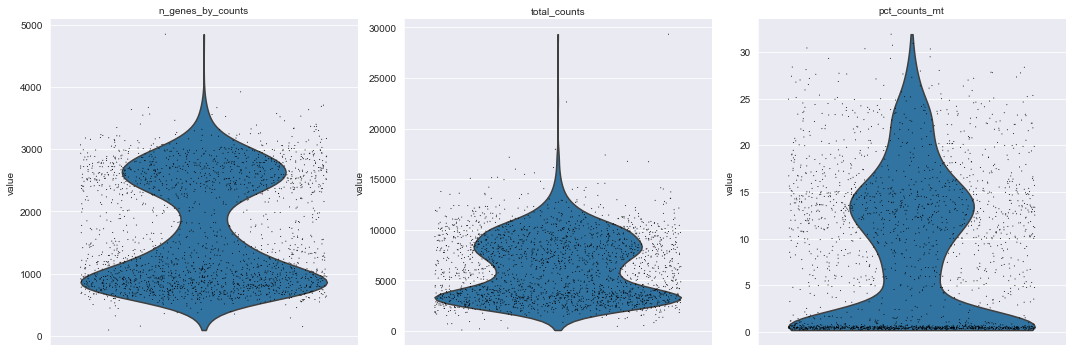

In [2]:
h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]
sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [3]:
sc.pp.filter_genes(adata, min_cells=500)
adata

AnnData object with n_obs × n_vars = 2179 × 2225
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [ ]:
result = convolve(get_3d_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

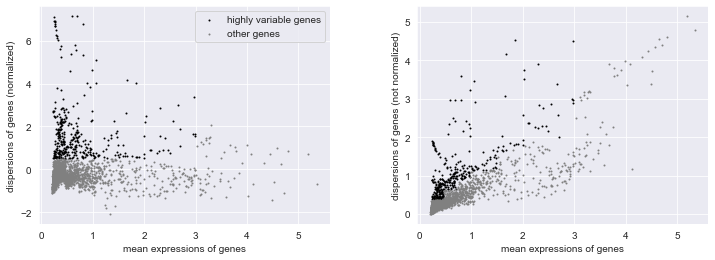

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [5]:
gene_list = adata.var[adata.var['highly_variable']==True].index

In [6]:
len(gene_list)

338

In [33]:
gmm_dict = fit_gmms(adata ,gene_list[:100],n_comp=20)

In [37]:
from Algorithm.graph import *
g = build_graph(gmm_dict, distance_threshold=1)
g = modify_graph(g)

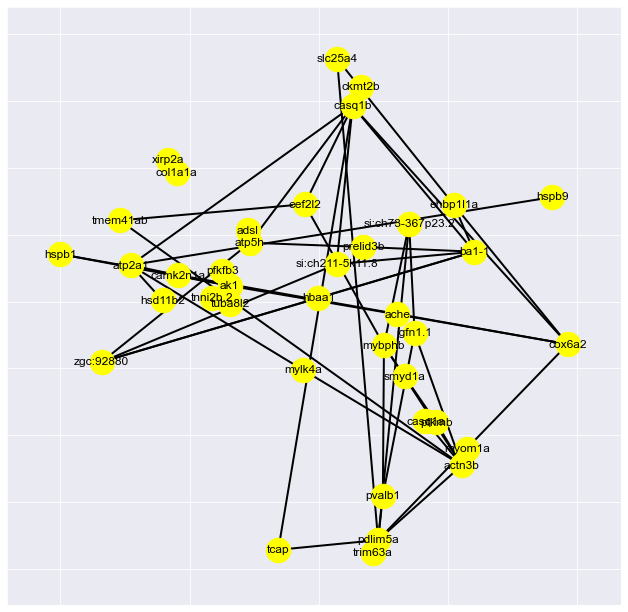

In [38]:
plt.figure(figsize=(11,11))
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos=pos,with_labels=True,node_size=600,width=2,node_color='yellow')
plt.show()

In [43]:
from sklearn.cluster import SpectralClustering
similarity_matrix  = nx.to_numpy_matrix(g)
laplacian_matrix = nx.laplacian_matrix(g).toarray()
# 对拉普拉斯矩阵进行特征分解
eigenvalues, eigenvectors = np.linalg.eig(laplacian_matrix)

# 取最小的k个特征向量，作为节点的表示
k = 2  # 聚类数
indices = eigenvalues.argsort()[:k]
k_smallest_eigenvectors = eigenvectors[:, indices]

# 对特征向量进行聚类
clustering_model = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=100)
clustering_model.fit(similarity_matrix)

# 打印聚类结果
print("Cluster labels:", clustering_model.labels_)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [46]:
nx.laplaci

TypeError: 'module' object is not callable

In [ ]:
list(nx.spring_layout(g).keys())

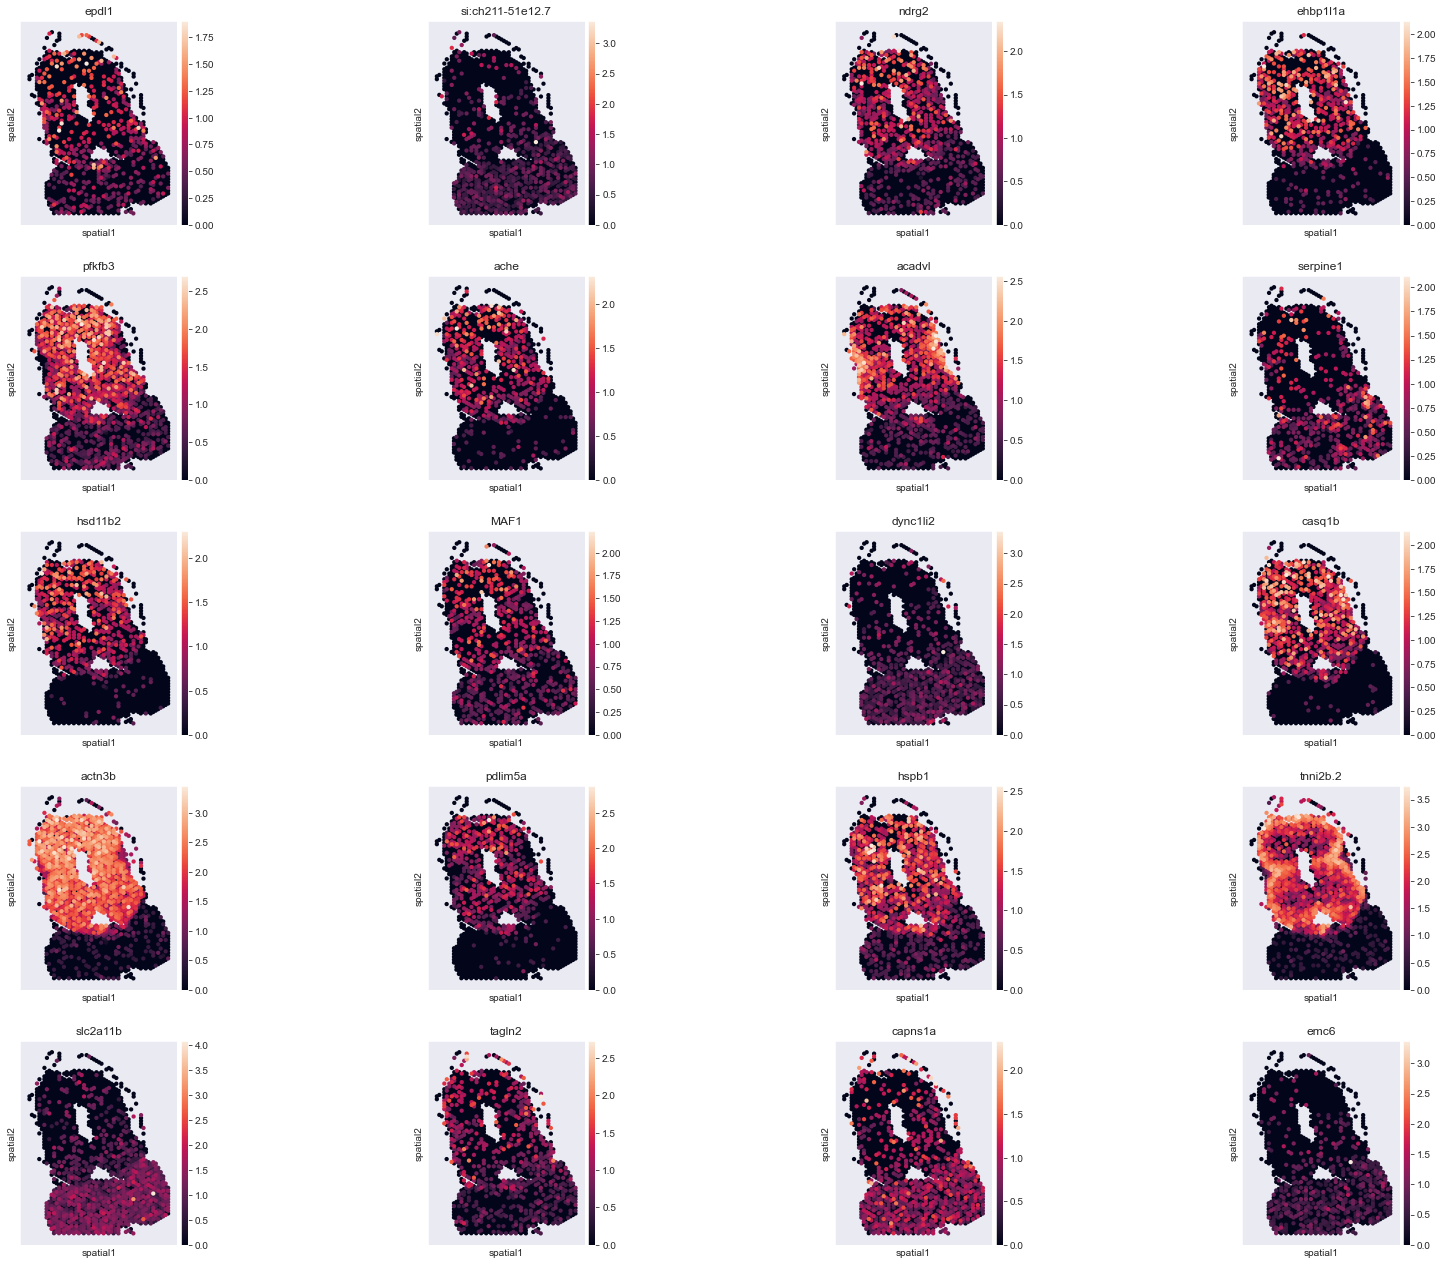

In [32]:
sc.pl.spatial(adata,
              size=2,
              spot_size=300,
              color=list(nx.spring_layout(g).keys())[:20])

In [ ]:
import networkx as nx

# 使用Louvain算法进行聚类
comp = nx.algorithms.community.girvan_newman(g)

# 打印结果
for i, c in enumerate(comp):
    print(f"Community {i+1}: {c}")

In [ ]:
import networkx as nx
adj_matrix = nx.to_numpy_matrix(g)

In [ ]:
degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
laplacian_matrix = degree_matrix - adj_matrix

eigenvalues, eigenvectors = np.linalg.eig(np.asarray(laplacian_matrix))

k = 10
U = eigenvectors[:, 0:k]

normalized_U = U / np.linalg.norm(U, axis=1).reshape(-1, 1)

from sklearn.cluster import KMeans

kmeans = KMeans()
kmeans.fit(normalized_U)


plt.scatter(np.array(U[:,0]), np.array(U[:,1]), c=kmeans.labels_)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# 使用贪心算法计算模块化谱图
communities = list(greedy_modularity_communities(g))

# 可视化模块化谱图
pos = nx.spring_layout(g)
for i, community in enumerate(communities):
    nx.draw_networkx_nodes(g, pos, nodelist=list(community), node_color=f'C{i}', node_size=100, alpha=0.8)
nx.draw_networkx_edges(g, pos, width=1, alpha=0.5)
plt.show()

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [ ]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

In [ ]:

sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [ ]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

In [ ]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro','tcap', 'mt2'])

In [ ]:
gmm1 = fit_gmm(adata, 'mt2')
gmm2 = fit_gmm(adata, 'ptpro')

In [ ]:
distribution_distance(gmm1, gmm2)

In [ ]:
view_gmm(gmm1)

In [ ]:
view_gmm(gmm2, '2d')